In [1]:
%matplotlib inline

In [2]:
from ankisync2 import Apkg
from tqdm import tqdm
import re
from bs4 import BeautifulSoup
import os
import itertools
import math
import sqlite3
from contextlib import closing
from time import sleep

import pandas as pd
import scipy as sp
import numpy as np

In [3]:
class Anki(object):
    THRESHOLD = 0.15  # Only record similarity values above threshold
    PARTIAL = None  # Only look at first n entries

    def __init__(self, file, overwrite=True, read=True):
        self.file = os.path.abspath(file)
        self.sql = SQL(f'{self.file}.sql')

        self.db = []

        self.all_cards = set()
        self.all_tags = set()
        self.all_imgs = set()
        self.n_cards = 0
        self.n_tags = 0
        self.n_imgs = 0

        self.note_sim = {'images': [], 'tags': [], 'text': [], 'overall': []}
        self.image_sim = {}
        self.tag_sim = {}

        if overwrite:
            self.sql.init_sql()

        if read:
            self.read_file()

    def read_file(self):
        with Apkg(self.file) as apkg:
            for card in tqdm(apkg, f'Reading `{self.file}`: ',
                             total=sum(1 for _ in apkg),
                             position=0, leave=True):

                note = card['note']
                content = dict(zip(note['model']['flds'], note['flds']))

                # Extracting images
                images = []
                for field in ['Text', 'Extra', 'Image', 'Lecture Notes',
                              'Missed Questions', 'Pathoma', 'Boards and Beyond',
                              'First Aid', 'Sketchy', 'Pixorize', 'Physeo',
                              'Additional Resources']:
                    imgs = Helpers.get_images(content.get(field))
                    if imgs:
                        images += imgs

                # Regularizing the 'Text' and 'Extra' fields
                if 'Text' in content.keys():
                    text = Helpers.clean_html_tags(
                        Helpers.remove_cloze(content['Text']))
                else:
                    try:
                        text = clean_html_tags(content['Header'])
                    except:
                        # A few of the in-house psych cards used a weird format
                        # Honestly just gonna skip
                        continue

                if 'Extra' in content.keys():
                    extra = Helpers.clean_html_tags(content['Extra'])
                else:
                    extra = ''

                out = {}
                out['id'] = note['id']
                out['data'] = f'{text} \n {extra}'
                out['images'] = set(images)
                out['tags'] = Helpers.telescope_tags(note['tags'])

                self.db.append(out)

        self.all_cards = set(card['id'] for card in self.db)
        self.all_tags = set(tag for taglist in [card['tags']
                                                for card in self.db]
                            for tag in taglist)
        self.all_imgs = set(img for imglist in [card['images']
                                                for card in self.db]
                            for img in imglist)
        self.calculate_n()
        self.serialize_sets()

#     def compute_note_similarity(self):
#         self.note_image_similarity()
#         self.note_tag_similarity()
#         self.note_text_similarity()
#         self.note_overall_similarity()

    def calculate_n(self):
        self.n_tags = len(self.all_tags)
        self.n_cards = len(self.db)
        self.n_imgs = len(self.all_imgs)

    def serialize_sets(self):
        print('Serializing total set of card IDs, images, and tags')
        self.sql.insert_vals(f'''
                              INSERT INTO cards (card_id)
                              VALUES (?)
                              ''', self.all_cards)
        self.sql.insert_vals(f'''
                              INSERT INTO tags (tag)
                              VALUES (?)
                              ''', self.all_tags)
        self.sql.insert_vals(f'''
                              INSERT INTO images (image)
                              VALUES (?)
                              ''', self.all_imgs)

    def note_image_similarity(self):
        res = self.note_list_similarity('images')
        return res

    def note_tag_similarity(self):
        res = self.note_list_similarity('tags')
        return res

    def note_text_similarity(self):
        pass  # TODO

    def note_overall_similarity(self):
        pass  # TODO

    def note_list_similarity(self, list_type):
        assert list_type.lower() in ['images', 'tags']
        res = []
        represented = []

        if self.PARTIAL:
            pairs = itertools.permutations(self.db[0:self.PARTIAL], 2)
            perms = self.PARTIAL * (self.PARTIAL - 1)
            n = self.PARTIAL
        else:
            pairs = itertools.permutations(self.db, 2)
            perms = self.n_cards * (self.n_cards - 1)
            n = self.n_cards

        for pair in tqdm(pairs, f'Calculating similarity of cards by their {list_type}: ',
                         total=perms, position=0, leave=True):
            sim = Helpers.jaccard_similarity(
                pair[0][list_type], pair[1][list_type])
            if sim > self.THRESHOLD:
                card1_id = pair[0]['id']
                card2_id = pair[1]['id']
                res.append((card1_id, card2_id, sim))
                if card1_id not in represented:
                    represented.append(card1_id)
                if card2_id not in represented:
                    represented.append(card2_id)

        print(f'{n} cards total. {len(represented)} cards represented in matrix '
              f'({100*len(represented)/n:.2f}%). '
              f'At theshold {self.THRESHOLD}, storing {len(res)} of {perms} combos '
              f'of {list_type} ({100*(1-len(res)/perms):.2f}% reduction)')

        tbl = list_type[:-1]
        print(f'Serializing results into table note_{tbl}_sim')
        self.serialize_note_similarity(tbl, res)
        return res

    # idc if I'm repeating myself in these next two funcs
    def tag_similarity(self):
        pairs = itertools.permutations(self.all_tags, 2)
        perms = self.n_tags * (self.n_tags - 1)

        res = []
        represented = []
        for pair in tqdm(pairs, f'Calculating similarity of tags: ',
                         total=perms, position=0, leave=True):
            tag1 = pair[0]
            tag2 = pair[1]
            tag1_cards = [card['id']
                          for card in self.db if tag1 in card['tags']]
            tag2_cards = [card['id']
                          for card in self.db if tag2 in card['tags']]
            sim = Helpers.jaccard_similarity(tag1_cards, tag2_cards)

            if sim != 0:
                res.append((tag1, tag2, sim))
                if tag1 not in represented:
                    represented.append(tag1)
                if tag2 not in represented:
                    represented.append(tag2)

        print(f'{self.n_tags} total. {len(represented)} tags represented in matrix '
              f'({100*len(represented)/self.n_tags:.2f}%). '
              f'Storing {len(res)} nonzero values of {perms} tag combos '
              f'({100*(1-len(res)/perms):.2f}% reduction).')
        print('Serializing tag similarity')
        self.sql.insert_vals(f'''
                              INSERT INTO tag_sim (tag_a, tag_b, value)
                              VALUES (?, ?, ?)
                              ''', res)
        return res

    def image_similarity(self):
        pairs = itertools.permutations(self.all_imgs, 2)
        perms = self.n_imgs * (self.n_imgs - 1)

        res = []
        represented = []
        for pair in tqdm(pairs, f'Calculating similarity of images: ',
                         total=perms, position=0, leave=True):
            img1 = pair[0]
            img2 = pair[1]
            img1_cards = [card['id']
                          for card in self.db if img1 in card['images']]
            img2_cards = [card['id']
                          for card in self.db if img2 in card['images']]
            sim = Helpers.jaccard_similarity(img1_cards, img2_cards)

            if sim != 0:
                res.append((img1, img2, sim))
                if img1 not in represented:
                    represented.append(img1)
                if img2 not in represented:
                    represented.append(img2)

        print(f'{self.n_imgs} total. {len(represented)} images represented in matrix '
              f'({100*len(represented)/self.n_imgs:.2f}%). '
              f'Storing {len(res)} nonzero values of {perms} image combos '
              f'({100*(1-len(res)/perms):.2f}% reduction).')
        print('Serializing image similarity')
        self.sql.insert_vals(f'''
                              INSERT INTO image_sim (image_a, image_b, value)
                              VALUES (?, ?, ?)
                              ''', res)
        return res

    def serialize_note_similarity(self, table, params):
        self.sql.insert_vals(f'''
                              INSERT INTO note_{table}_sim (card_a, card_b, value)
                              VALUES (?, ?, ?)
                              ''', params)

    def load_from_db(self):
        print(f'Loading from database {self.sql.path}')

        self.all_cards = set(self.sql.execute('SELECT * FROM cards')['card_id'])
        self.all_tags = set(self.sql.execute('SELECT * FROM tags')['tag'])
        self.all_imgs = set(self.sql.execute('SELECT * FROM images')['image'])
        self.calculate_n()

        self.note_sim['images'] = self.sql.execute(
            'SELECT * from note_image_sim;')
        self.note_sim['tags'] = self.sql.execute('SELECT * from note_tag_sim;')
        self.note_sim['text'] = self.sql.execute(
            'SELECT * from note_text_sim;')
        self.note_sim['overall'] = self.sql.execute(
            'SELECT * from note_overall_sim;')
        self.tag_sim = self.sql.execute('SELECT * from tag_sim;')
        self.image_sim = self.sql.execute('SELECT * from image_sim;')

    def set_threshold(self, threshold=0.15):
        self.THRESHOLD = threshold


class SQL(object):
    DELAY = 0.5  # Just for display purposes

    def __init__(self, path):
        self.path = path

    def init_sql(self):
        print(f'Creating new storage db at {self.path}')
        conn = sqlite3.connect(self.path)
        cursor = conn.cursor()
        for tbl in ['cards', 'tags', 'images',
                    'note_image_sim', 'note_tag_sim', 'note_text_sim', 'note_overall_sim',
                    'tag_sim', 'image_sim']:
            cursor.execute(f'DROP TABLE IF EXISTS {tbl}')

        cursor.execute('CREATE TABLE cards (card_id integer);')
        cursor.execute('CREATE TABLE tags (tag string);')
        cursor.execute('CREATE TABLE images (image string);')
        cursor.execute('CREATE INDEX cards_idx ON cards (card_id);')
        cursor.execute('CREATE INDEX tags_idx ON tags (tag);')
        cursor.execute('CREATE INDEX images_idx ON images (image);')

        cursor.execute('''
                       CREATE TABLE note_image_sim
                       (card_a integer, 
                       card_b integer,
                       value real,
                       
                       FOREIGN KEY (card_a) REFERENCES cards (card_id) ON DELETE CASCADE,
                       FOREIGN KEY (card_b) REFERENCES cards (card_id) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX note_image_sim_idx ON note_image_sim (card_a, card_b);')
        cursor.execute('''
                       CREATE TABLE note_tag_sim
                       (card_a integer, 
                       card_b integer,
                       value real,
                       
                       FOREIGN KEY (card_a) REFERENCES cards (card_id) ON DELETE CASCADE,
                       FOREIGN KEY (card_b) REFERENCES cards (card_id) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX note_tag_sim_idx ON note_tag_sim (card_a, card_b);')
        cursor.execute('''
                       CREATE TABLE note_text_sim
                       (card_a integer, 
                       card_b integer,
                       value real,
                       
                       FOREIGN KEY (card_a) REFERENCES cards (card_id) ON DELETE CASCADE,
                       FOREIGN KEY (card_b) REFERENCES cards (card_id) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX note_text_sim_idx ON note_text_sim (card_a, card_b);')
        cursor.execute('''
                       CREATE TABLE note_overall_sim
                       (card_a integer, 
                       card_b integer,
                       value real,
                       
                       FOREIGN KEY (card_a) REFERENCES cards (card_id) ON DELETE CASCADE,
                       FOREIGN KEY (card_b) REFERENCES cards (card_id) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX note_overall_sim_idx ON note_overall_sim (card_a, card_b);')
        cursor.execute('''
                       CREATE TABLE tag_sim
                       (tag_a string, 
                       tag_b string,
                       value real,
                       
                       FOREIGN KEY (tag_a) REFERENCES tags (tag) ON DELETE CASCADE,
                       FOREIGN KEY (tag_b) REFERENCES tags (tag) ON DELETE CASCADE);
                       ''')
        cursor.execute('CREATE INDEX tag_sim_idx ON tag_sim (tag_a, tag_b);')
        cursor.execute('''
                       CREATE TABLE image_sim
                       (image_a string, 
                       image_b string,
                       value real,
                       
                       FOREIGN KEY (image_a) REFERENCES images (image) ON DELETE CASCADE,
                       FOREIGN KEY (image_b) REFERENCES images (image) ON DELETE CASCADE);
                       ''')
        cursor.execute(
            'CREATE INDEX image_sim_idx ON image_sim (image_a, image_b);')
        conn.commit()
        conn.close()

    def execute(self, sql, params=()):
        with closing(sqlite3.connect(self.path)) as conn:
            with conn:
                cur = conn.cursor()
                try:
                    sleep(self.DELAY)
                    cur.execute(sql, params)
                    res = cur.fetchall()
                except sqlite3.ProgrammingError:
                    print(f'SQL:\n{sql}\n{params}')

                if res:
                    df = pd.DataFrame(res)
                    df.columns = [d[0] for d in cur.description]
                else:
                    df = pd.DataFrame({})
        return df

    def insert_vals(self, sql, param_list):
        with closing(sqlite3.connect(self.path)) as conn:
            with conn:
                cur = conn.cursor()
                try:
                    sleep(self.DELAY)
                    for params in tqdm(param_list, 'Serializing', position=0, leave=True):
                        if isinstance(params, int) or isinstance(params, str):
                            cur.execute(sql, (params,))
                        else:
                            cur.execute(sql, params)
                    res = cur.fetchall()
                except:
                    print(f'SQL:\n{sql}\n{params}')
                    res = None

                if res:
                    df = pd.DataFrame(res)
                    df.columns = [d[0] for d in cur.description]
                else:
                    df = pd.DataFrame({})
        return df


class Helpers(object):
    def __init__(self):
        pass

    @staticmethod
    def clean_html_tags(markup):
        soup = BeautifulSoup(markup, 'html.parser')
        for br in soup.find_all('br'):
            br.replace_with('\n')
        return soup.get_text()

    @staticmethod
    def get_images(markup):
        out = []
        if markup:
            soup = BeautifulSoup(markup, 'html.parser')
            images = soup.findAll('img')
            for image in images:
                out.append(image['src'])
        return out

    @staticmethod
    def remove_cloze(markup):
        # txt = '<a href="blah"> Hello {{c1::world}} once {{c2::again::hint}} lol </a>'
        return re.sub('{{.*?::(.*?)(::.*?){0,}}}', '\\1', markup)

    @staticmethod
    def telescope_tags(taglist):
        out = []
        for tag in taglist:
            splt = tag.lower().split('::')
            for i in range(1, len(splt)):
                out.append('::'.join(splt[0:i]))
        return set(out)

    @staticmethod
    def jaccard_similarity(list1, list2):
        s1 = set(list1)
        s2 = set(list2)
        try:
            jaccard = float(len(s1.intersection(s2)) / len(s1.union(s2)))
        except ZeroDivisionError:
            jaccard = 0
        return jaccard

# TODO: Calculate similarity based on text
# TODO: Calculate network fusion

# TODO: combine all the whitespace? Handle punctuation?


In [4]:
file = 'Subset.apkg' # Selected Notes.apkg or Subset.apkg

x = Anki(file)
x.set_threshold(0.15)
x.note_image_similarity()
x.note_tag_similarity()
# x.note_text_similarity()
# x.note_overall_similarity()
x.tag_similarity()
x.image_similarity()


Creating new storage db at /mnt/c/Users/edrid.EDRIDGE-DSOUZA-/Documents/GitHub/anki-network/Subset.apkg.sql


Reading `/mnt/c/Users/edrid.EDRIDGE-DSOUZA-/Documents/GitHub/anki-network/Subset.apkg`: 100%|██████████| 572/572 [00:00<00:00, 639.36it/s]


Serializing total set of card IDs, images, and tags


Calculating similarity of cards by their images: 100%|██████████| 284622/284622 [00:00<00:00, 793506.20it/s]


534 cards total. 227 cards represented in matrix (42.51%). At theshold 0.15, storing 2098 of 284622 combos of images (99.26% reduction)
Serializing results into table note_image_sim


Calculating similarity of cards by their tags: 100%|██████████| 284622/284622 [00:01<00:00, 254152.24it/s]


534 cards total. 358 cards represented in matrix (67.04%). At theshold 0.15, storing 136468 of 284622 combos of tags (52.05% reduction)
Serializing results into table note_tag_sim


Calculating similarity of tags: 100%|██████████| 193160/193160 [00:10<00:00, 17824.10it/s]


440 total. 440 tags represented in matrix (100.00%). Storing 19518 nonzero values of 193160 tag combos (89.90% reduction).
Serializing tag similarity


Calculating similarity of images: 100%|██████████| 858402/858402 [00:36<00:00, 23721.75it/s]


927 total. 894 images represented in matrix (96.44%). Storing 6428 nonzero values of 858402 image combos (99.25% reduction).
Serializing image similarity


Serializing: 100%|██████████| 6428/6428 [00:00<00:00, 113537.15it/s]


[('recovery tubular recovery_1566160514431.jpg',
  'Screen Shot 2019-12-28 at 6.30.07 PM.JPG',
  0.3333333333333333),
 ('recovery tubular recovery_1566160514431.jpg',
  'Screen Shot 2019-11-12 at 8.53.18 AM.png',
  0.6666666666666666),
 ('recovery tubular recovery_1566160514431.jpg',
  'paste-3620631660724656.png',
  0.5),
 ('recovery tubular recovery_1566160514431.jpg',
  'tmppbNN6g.png',
  0.3333333333333333),
 ('recovery tubular recovery_1566160514431.jpg',
  'tmpradjkT.png',
  0.3333333333333333),
 ('recovery tubular recovery_1566160514431.jpg',
  'paste-108971910234113.jpg',
  0.5),
 ('Screen Shot 2020-02-12 at 11.33.25 AM.JPG',
  'paste-88905823028828.jpg',
  1.0),
 ('Screen Shot 2020-02-12 at 11.33.25 AM.JPG',
  'paste-74059d6e57434268b55465ea3f7834a05e372a68.jpg',
  1.0),
 ('Screen Shot 2020-02-12 at 11.33.25 AM.JPG',
  'Screen Shot 2020-02-12 at 11.33.33 AM.JPG',
  1.0),
 ('Screen Shot 2020-02-12 at 11.33.25 AM.JPG', 'tmpzfb6pX.png', 0.5),
 ('Screen Shot 2020-02-12 at 11.33.25

In [5]:
x.db[100]

{'id': 1473986325018,
 'data': "Hemolytic uremic syndrome is classically seen in children with E. coli O157:H7 dysentery, which results from exposure to undercooked beef\n\n \n HUS in adults often doesn't have diarrhea because adults are less susceptible to this strain of E coli\n\nShiga-like toxin (verotoxin) produced by E. coli 0157:H7--> toxin absorbed through GImucosa --> toxin binds to endothelial cells (particularly in glomerulus) -->platelet activation and aggregation\n*Most recent information showed the verotoxin inhibits ADAMTS13 similar to how TTP has autoimmunity against ADAMTS13\n\n",
 'images': {'Screen Shot 2020-02-13 at 3.40.35 PM.JPG',
  'Screen Shot 2020-02-13 at 3.40.46 PM.JPG',
  'Screen Shot 2020-02-13 at 3.40.58 PM.JPG',
  'Zoverall picture (74)_1566160514431.JPG',
  'tmp4eLODm.png',
  'tmp4lRjJP.png',
  'tmpyyGRpv.png',
  'ttp.jpg'},
 'tags': {'#ak_step1_v9',
  '#ak_step1_v9::#b&b',
  '#ak_step1_v9::#b&b::11_hematology',
  '#ak_step1_v9::#b&b::11_hematology::01_he

In [71]:
x = Anki(file, overwrite=False, read=False)
x.load_from_db()
print('Done')

Loading from database /mnt/c/Users/edrid.EDRIDGE-DSOUZA-/Documents/GitHub/anki-network/Subset.apkg.sql
Done


In [7]:
# Doc2Vec for similarity scores:
# https://medium.com/red-buffer/doc2vec-computing-similarity-between-the-documents-47daf6c828cd
# https://stackoverflow.com/questions/53503049/measure-similarity-between-two-documents-using-doc2vec
# https://github.com/jhlau/doc2vec#pre-trained-doc2vec-models

# https://github.com/rmarkello/snfpy to fuse similarity networks
# https://github.com/maxconway/SNFtool has more visualization options
# sklearn to do general network stuff
# https://towardsdatascience.com/visualising-similarity-clusters-with-interactive-graphs-20a4b2a18534

In [8]:
from gensim.models import doc2vec
from scipy import spatial

d2v_model = doc2vec.Doc2Vec.load(model_file)

fisrt_text = '..'
second_text = '..'

vec1 = d2v_model.infer_vector(fisrt_text.split())
vec2 = d2v_model.infer_vector(second_text.split())

cos_distance = spatial.distance.cosine(vec1, vec2)
# cos_distance indicates how much the two texts differ from each other:
# higher values mean more distant (i.e. different) texts

NameError: name 'model_file' is not defined

/home/edsouza/anaconda3/lib/python3.7/site-packages/seaborn/matrix.py:284: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  cmap=self.cmap, **kws)


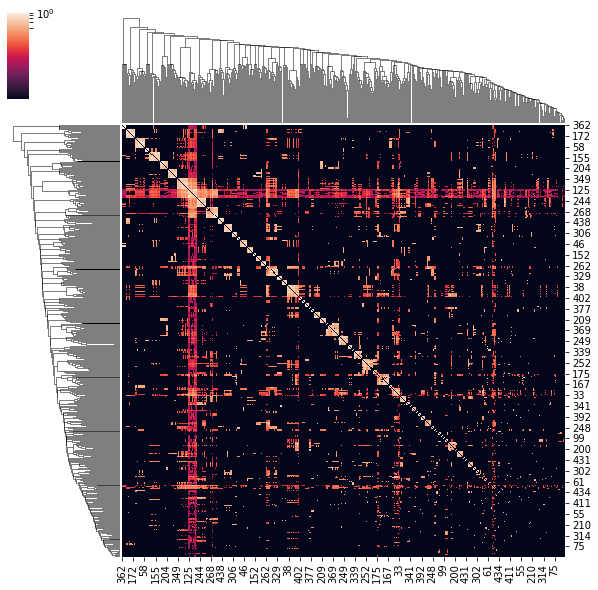

In [120]:
from matplotlib.colors import LogNorm, Normalize

all_tags = list(x.all_tags)
sim = x.tag_sim.copy()
sim.tag_a = sim.tag_a.map(lambda tag: all_tags.index(tag))
sim.tag_b = sim.tag_b.map(lambda tag: all_tags.index(tag))


from scipy.sparse import coo_matrix

tmp = coo_matrix((sim.value, (sim.tag_a, sim.tag_b)), shape=(440, 440)).toarray()

sns.clustermap(tmp + 0.0001, norm=LogNorm())

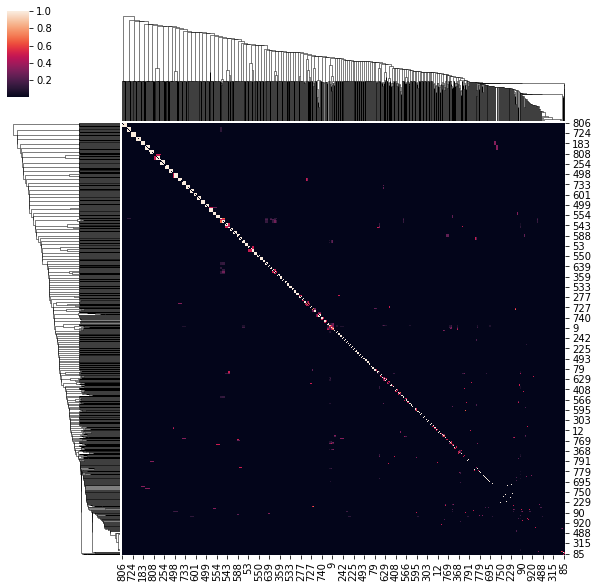

In [112]:
from matplotlib.colors import LogNorm, Normalize

all_images = list(x.all_imgs)
sim = x.image_sim.copy()
sim.image_a = sim.image_a.map(lambda img: all_images.index(img))
sim.image_b = sim.image_b.map(lambda img: all_images.index(img))


from scipy.sparse import coo_matrix

tmp = coo_matrix((sim.value, (sim.image_a, sim.image_b)), shape=(len(all_images), len(all_images))).toarray()

sns.clustermap(tmp + 0.0001,norm=)